# This part runs before Vivado

This part generates filter coefficient hex representations as well as the chirp input you'll feed your DUT in Vivado

In [1]:
import numpy as np
from scipy.signal import chirp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
### Coefficient array for the 17-tap filter at 100 MHz
Coeff = np.asarray([
    0.06725647, 0.0745969 , 0.08130106, 0.08723073, 0.0922625 ,
    0.09629086, 0.09923084, 0.10102019, 0.10162089, 0.10102019,
    0.09923084, 0.09629086, 0.0922625 , 0.08723073, 0.08130106,
    0.0745969 , 0.06725647
]);

Data_Width = 16;
Max        = (2**(Data_Width-1)-1);
Coeff_int  = np.round(Coeff*Max);

vhex = np.vectorize(hex)
vhex(Coeff_int.astype(np.int16))

array(['0x89c', '0x98c', '0xa68', '0xb2a', '0xbcf', '0xc53', '0xcb3',
       '0xcee', '0xd02', '0xcee', '0xcb3', '0xc53', '0xbcf', '0xb2a',
       '0xa68', '0x98c', '0x89c'], dtype='<U5')

same numbers, VHDL array format:

    x"089c", x"098c", x"0a68", x"0b2a", x"0bcf", x"0c53", x"0cb3",
    x"0cee", x"0d02", x"0cee", x"0cb3", x"0c53", x"0bcf", x"0b2a",
    x"0a68", x"098c", x"089c"

In [3]:
clock_period_in_ns  = 10;
time_stop_in_ns   = 1e6;

number_of_pts_in_testarray = int(time_stop_in_ns/clock_period_in_ns);

t = np.linspace(0, time_stop_in_ns/1e9, number_of_pts_in_testarray) # 0=t_start. Every tick in t corresponds to one clock cycle in the testbench

chirp_start_freq_hz = 1e6; # our LPF has a cutoff at 3 MHz, we're sweeping from 1 to 5 to see the drop in power
chirp_stop_freq_hz  = 5e6;

x = chirp(t, f0=chirp_start_freq_hz, f1=chirp_stop_freq_hz, t1=time_stop_in_ns/1e9, method='linear');

In [4]:
Text_file_input = 'Filter_input.txt';

x_int = np.round(x*Max);

In [5]:
with open(Text_file_input, "w") as txt_file:
    for xi in x_int:
        txt_file.write(str(xi.astype(np.int16)) + "\n")

for Google Colab: download "Filter_input.txt" from the left hand side of your screen (expand the drive tab by clicking on the folder icon on the left if you don't see any files on the left), and feed it to your Vivado testbench to generate "Filter_output.txt"

In [6]:
y_ref_real = np.convolve(x, Coeff)*(2**(Data_Width-1)); # converting to the Q0.15 format but in the signed integer way
y_ref_int  = np.convolve(x_int, Coeff_int);
y_ref_int  = (y_ref_int.astype(float)/(2**(Data_Width-1))).astype(int); # discarding least significant 16 bits

In [7]:
y_ref_int  = np.concatenate((np.zeros(4,dtype=int), y_ref_int));
y_ref_real = np.concatenate((np.zeros(4), y_ref_real));

# This part runs after Vivado

After running your testbench in Vivado, "Filter_output.txt" gets generated. For Google Colab: Upload that file to the Colab runtime on the left hand side of your screen before running the cells below.

In [8]:
with open(Text_file_input) as f:
    inp_list = []
    for line in f:
        inp_list.append(int(line))

Text_file_output = "Filter_output.txt";
with open(Text_file_output) as f:
    out_list = []
    for line in f:
        out_list.append(int(line))

out_list = np.asarray(out_list)

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

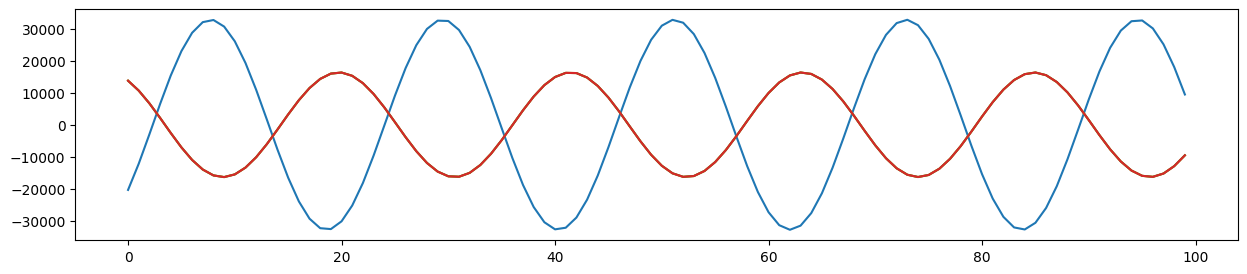

In [10]:
s_smpls = 90100
e_smpls = 90200
figure(figsize=(15, 3))
plt.plot(inp_list[s_smpls:e_smpls])
plt.plot(out_list[s_smpls:e_smpls])
plt.plot(y_ref_int[s_smpls:e_smpls])
plt.plot(y_ref_real[s_smpls:e_smpls])

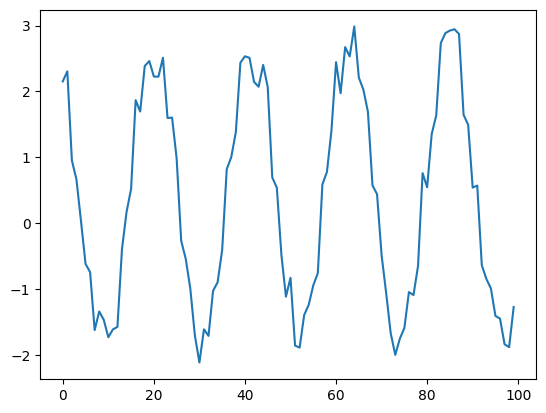

In [11]:
quantization_error = y_ref_real[:-20]-out_list
plt.plot(quantization_error[s_smpls:e_smpls])

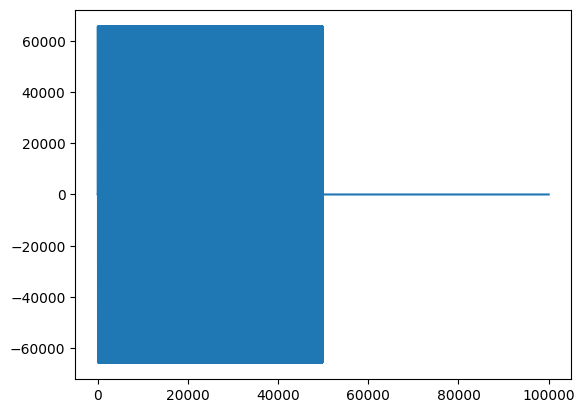

In [12]:
plt.plot(quantization_error)

In [13]:
print(quantization_error.max())
print(quantization_error.min())
print(quantization_error.sum()/quantization_error.shape[0])

65542.39854592158
-65541.52957677323
10.986343398143335


the cell below draws a histogram of quantization errors of the whole array

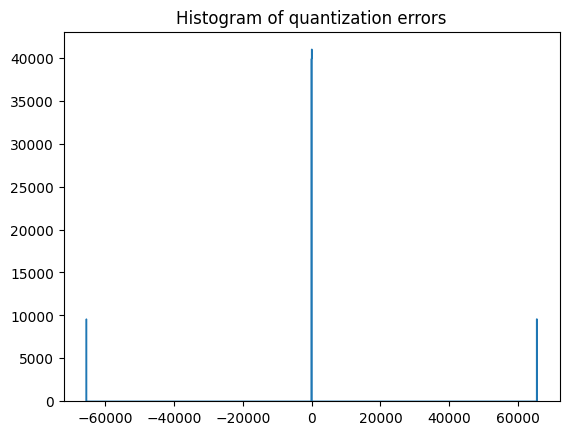

In [14]:
_ = plt.hist(quantization_error, bins=1000, histtype='step')  # arguments are passed to np.histogram
plt.title("Histogram of quantization errors")
plt.show()

the cell below draws a histogram of quantization errors for the last 3/4s of the whole array

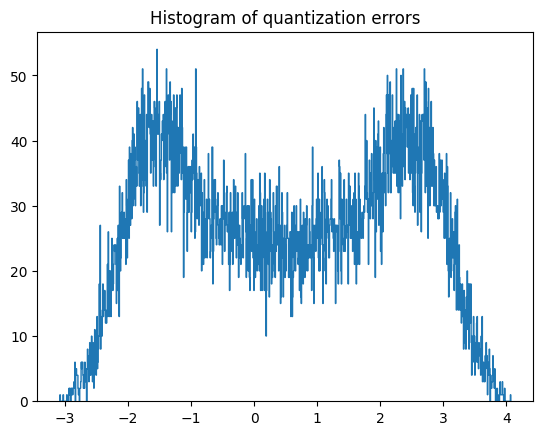

In [15]:
_ = plt.hist(quantization_error[int(3*quantization_error.shape[0]/4):], bins=1000, histtype='step')  # arguments are passed to np.histogram
plt.title("Histogram of quantization errors")
plt.show()

the 65000-level errors are due to the glitches, they shouldn't have happened, the second histogram is the expected one, with most quantization errors grouped around 0